### **Configurando o Notebook**

In [ ]:
# Instalação do PyCaret
# !pip install pycaret
# !pip install fpdf

In [32]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm #5-Validação estatística
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score #5-Validação estatística
from scipy import stats #5-Validação estatística
from fpdf import FPDF

from pycaret.regression import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    silhouette_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score,
    PredictionErrorDisplay,
)

from IPython.display import display
from IPython.core.display import HTML

import warnings

warnings.filterwarnings("ignore")

display(HTML("<style = font-size>pre {white-space: pre !important;}</style>"))

data_dir = "./data"

SEED = 1123

np.random.seed(SEED)

In [33]:
def Kmeans_cluster(data, k):
    # 1. Inicializa o modelo K-Means com k clusters
    my_kmeans = KMeans(n_clusters = k, random_state = SEED)

    # 2. Ajusta (fit) o modelo aos dados fornecidos
    my_kmeans.fit(data)  # Passa os dados escalados aqui

    # 3. Obtém os clusters (rótulos) previstos para cada ponto de dado
    clusters = my_kmeans.predict(data)  # Passa os dados escalados aqui

    # 4. Obtém as coordenadas dos centróides dos clusters
    centroids = my_kmeans.cluster_centers_

    # 5. Retorna os clusters atribuídos e um DataFrame com os centróides
    return clusters, pd.DataFrame(centroids)
    # 6. Anexa a saída dos clusters ao nosso DataFrame original

In [34]:
def scaler(scaler, data: pd.DataFrame, columns: list = None):
    # Verifica se a lista de colunas foi fornecida
    if columns is None:
        # Se não, define todas as colunas do DataFrame como alvo
        columns = data.columns

    # Itera sobre cada coluna na lista de colunas
    for column in columns:
        # Aplica o escalonamento à coluna específica e substitui os valores originais pelos valores escalonados
        data[column] = pd.DataFrame(scaler.fit_transform(data[[column]]))

    # Retorna o DataFrame com as colunas escalonadas
    return data

### **1. Exploração de Dados**

**Requisito:** Carregue a base de dados e explore suas características. Analise estatísticas descritivas e visualize distribuições relevantes.

**Exemplo de Código e Resultados:**

In [35]:
# Carrega informações no dataframe
df_insurance = pd.read_csv(f"{data_dir}/insurance.csv")

In [36]:
# Data Cleaning - Não foi identificado dados inválidos
df_insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [37]:
# Data Analysis

# Gerando tabela com dados estatística descritiva
df_insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Explicação:**

- Carregamos a base de dados **`insurance.csv`**.
- Exploramos as primeiras linhas do DataFrame para entender a estrutura dos dados.
- Geramos estatísticas descritivas para entender a distribuição das variáveis.

### **2. Pré-processamento de Dados**

**Requisito:** Realize a limpeza dos dados, tratando valores ausentes (se necessário). Converta variáveis categóricas em formatos adequados para modelagem.

**Exemplo de Código e Resultados:**

In [38]:
# Feature Engineering - Parte 1/2 - Criação de novos campos antes da clusterização

# Calcula o ano de nascimento com base na idade
df_insurance["born_year"] = (pd.Timestamp.now() - (df_insurance["age"] * np.timedelta64(365, "D"))).dt.year

# Cria uma coluna booleana indicando se o indivíduo tem filhos
df_insurance["has_children"] = df_insurance["children"] > 0

# Converte variáveis categóricas em variáveis dummy
df_insurance = pd.get_dummies(df_insurance, drop_first=True)


In [39]:
# Data Transformation
# <<< A aplicação da técnica de Padronização diminui a acurácia neste modelo >>>

aplicar_padronizacao = True
if aplicar_padronizacao:  
  data_scaled = scaler(MinMaxScaler(), df_insurance.copy(), columns=['age', 'bmi', 'children', 'charges', 'born_year'])
  # O trecho acima aplica a técnica de MinMaxScaler para normalizar as colunas especificadas.
  # No entanto, foi comentado porque a padronização diminuiu a acurácia do modelo.
else:
  # Copia o DataFrame original sem aplicar escalonamento
  data_scaled = df_insurance.copy()
  # A linha acima mantém os dados sem escalonamento, copiando o DataFrame original.


In [40]:
# Realiza a clusterização com K-Means consideando 4 clusters
clusters, centroids = Kmeans_cluster(data_scaled, 4)

In [41]:
# Feature Engineering - Parte 2/2 - Após clusterização

# Adiciona os rótulos dos clusters ao DataFrame original
df_insurance["cluster"] = clusters

# Converte a coluna "cluster" para o tipo de dado categórico
df_insurance["cluster"] = df_insurance["cluster"].astype("category")

# Converte variáveis categóricas em variáveis dummy (indicadoras)
df_insurance = pd.get_dummies(df_insurance, drop_first=True)

# Exibe um resumo das informações do DataFrame atualizado
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   born_year         1338 non-null   int32  
 5   has_children      1338 non-null   bool   
 6   sex_male          1338 non-null   bool   
 7   smoker_yes        1338 non-null   bool   
 8   region_northwest  1338 non-null   bool   
 9   region_southeast  1338 non-null   bool   
 10  region_southwest  1338 non-null   bool   
 11  cluster_1         1338 non-null   bool   
 12  cluster_2         1338 non-null   bool   
 13  cluster_3         1338 non-null   bool   
dtypes: bool(9), float64(2), int32(1), int64(2)
memory usage: 58.9 KB


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>],
       [<Axes: title={'center': 'born_year'}>, <Axes: >]], dtype=object)

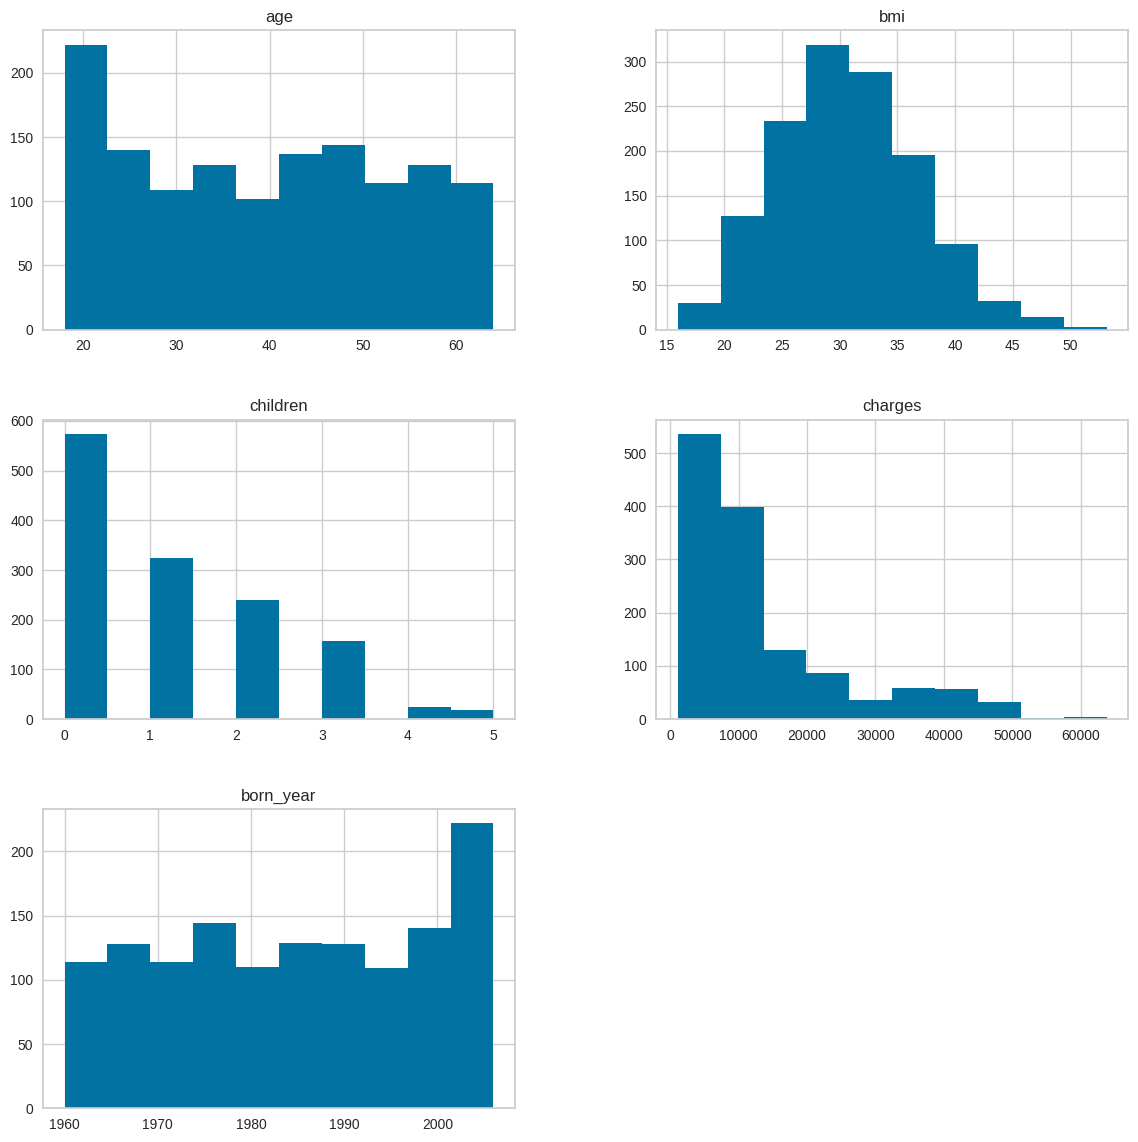

In [42]:
# Data Analysis

# Gera histogramas para todas as colunas numéricas do DataFrame
df_insurance.hist(figsize=(14, 14))

<Axes: >

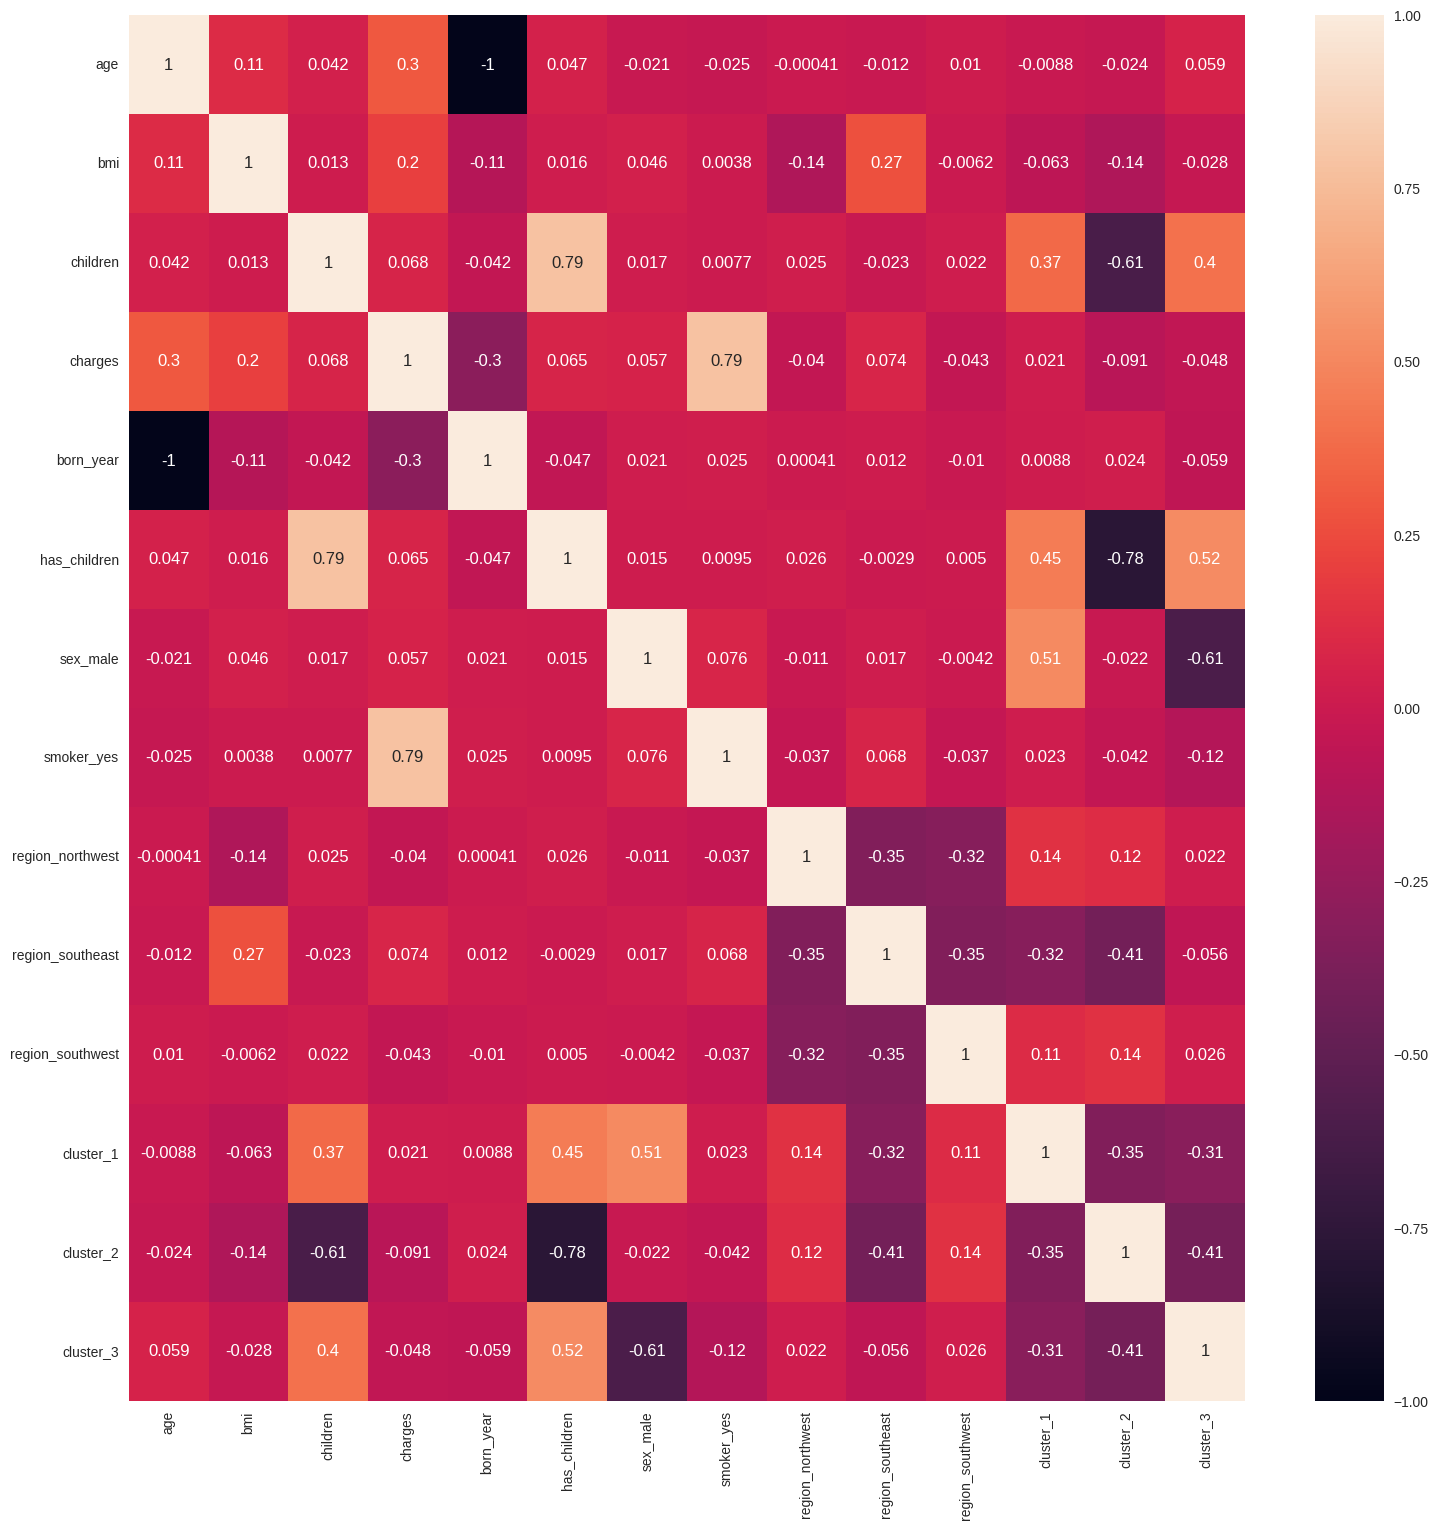

In [43]:
# Data Analysis

# Cria uma figura e eixos para o gráfico de calor (heatmap)
fig, ax = plt.subplots(figsize=(18, 18))

# Gera um heatmap das correlações entre as variáveis do DataFrame
sns.heatmap(df_insurance.corr(), ax=ax, annot=True)#, linewidths=0.8,)
# df_insurance.corr() #: Calcula a matriz de correlação entre as colunas numéricas do DataFrame.


**Explicação:**

- Verificamos valores ausentes e tratamos os dados.
- Criamos novas features **`born_year`** e **`has_children`**.
- Convertimos variáveis categóricas para variáveis dummy.


### **3. Modelagem**

**Requisito:** Crie um modelo preditivo de regressão utilizando uma técnica à sua escolha. Divida o conjunto de dados em conjuntos de treinamento e teste.

**Exemplo de Código e Resultados:**

In [44]:
# Divide os dados em conjuntos de treinamento e validação
train_data, validation_data = train_test_split(
    df_insurance, train_size=0.8, random_state=SEED, shuffle=True
)
# A linha acima divide o DataFrame df_insurance em dois subconjuntos:
# train_data: Contém 80% dos dados para treinamento.
# validation_data: Contém 20% dos dados para validação.
# train_size=0.8: Especifica que 80% dos dados devem ser usados para o treinamento.
# random_state=123: Define uma semente para o gerador de números aleatórios para garantir a reprodutibilidade da divisão.
# shuffle=True: Embaralha os dados antes de dividi-los para garantir que a divisão seja aleatória.


In [45]:
# Exibe as dimensões do conjunto de dados de treinamento
train_data.shape
# A linha acima retorna uma tupla contendo o número de linhas e colunas do DataFrame train_data.
# Isso é útil para verificar o tamanho do conjunto de treinamento e garantir que ele foi dividido corretamente.


(1070, 14)

In [46]:
# Exibe as dimensões do conjunto de dados de validação
validation_data.shape
# A linha acima retorna uma tupla contendo o número de linhas e colunas do DataFrame validation_data.
# Isso é útil para verificar o tamanho do conjunto de validação e garantir que ele foi dividido corretamente.


(268, 14)

**Explicação:**

- Dividimos os dados em conjuntos de treinamento e validação.
- Usamos o PyCaret para configurar e treinar um modelo de regressão, selecionando o melhor modelo baseado em métricas de desempenho.

### **4. Treinamento e Avaliação do Modelo**

**Requisito:** Treine o modelo com o conjunto de treinamento.

**Exemplo de Código e Resultados:**

In [47]:
# Cria uma nova instância de um experimento de regressão
experiment = RegressionExperiment()
# A linha acima inicializa um objeto RegressionExperiment,
# que facilita a configuração e execução de experimentos de regressão usando PyCaret.

# Configura o experimento de regressão
experiment.setup(
    data=train_data,          # Define o conjunto de dados de treinamento
    train_size=0.9,           # Especifica que 90% dos dados devem ser usados para treinamento e 10% para teste
    target="charges",         # Define a coluna alvo que o modelo deve prever
    session_id=SEED,           # Define uma semente para reprodutibilidade
    use_gpu=False              # Habilita o uso de GPU para acelerar o treinamento, se disponível
)
# A linha acima configura o experimento de regressão com os parâmetros especificados:
# - data=train_data: O conjunto de dados usado para configurar o experimento.
# - train_size=0.9: Proporção dos dados de treinamento que será usada para treinar os modelos.
# - target="charges": Nome da coluna que contém o valor a ser previsto.
# - session_id=123: Semente usada para reprodutibilidade dos resultados.
# - use_gpu=True: Indica que a GPU deve ser usada para acelerar o treinamento, se disponível.


,Description,Value
0,Session id,1123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1070, 14)"
4,Transformed data shape,"(1070, 14)"
5,Transformed train set shape,"(963, 14)"
6,Transformed test set shape,"(107, 14)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [48]:
# Compara diferentes modelos de regressão e seleciona o melhor
best_model = experiment.compare_models() #exclude=["lightgbm", "gbr"])
# A linha acima compara vários modelos de regressão disponíveis no PyCaret e retorna o melhor modelo com base em métricas de desempenho.
# A lista excluída foi comentada, mas, se ativada, excluiria os modelos "lightgbm" (LightGBM) e "gbr" (Gradient Boosting Regressor) da comparação.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2504.8620,20714110.2345,4517.2339,0.8553,0.4279,0.2933,0.0110
rf,Random Forest Regressor,2699.0316,23636327.2141,4829.3787,0.8348,0.4663,0.3247,0.0240
lightgbm,Light Gradient Boosting Machine,2874.4152,23623875.7292,4827.8368,0.8336,0.5654,0.3617,0.1120
ada,AdaBoost Regressor,4079.0946,26245241.5682,5103.0749,0.8154,0.6023,0.6800,0.0040
et,Extra Trees Regressor,2786.1597,28076608.6738,5272.4557,0.8020,0.4894,0.3293,0.0180
ridge,Ridge Regression,4228.4520,37066801.6772,6063.2186,0.7402,0.6330,0.4413,0.0030
br,Bayesian Ridge,4224.8739,37067928.9670,6063.3119,0.7401,0.6354,0.4408,0.0030
lr,Linear Regression,4213.9564,37076380.4413,6064.0632,0.7400,0.6068,0.4393,0.1110
lasso,Lasso Regression,4215.7139,37068680.5263,6063.3035,0.7400,0.6079,0.4394,0.0640
llar,Lasso Least Angle Regression,4307.9598,37708955.6510,6117.1593,0.7329,0.6206,0.4750,0.0040


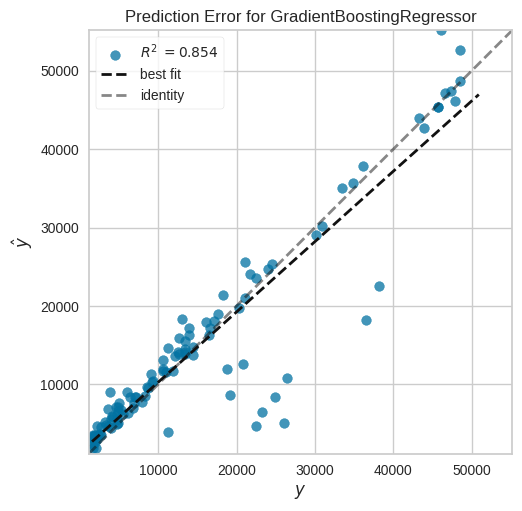

In [49]:
# Avaliando a performance do modelo

# Nos gráficos a seguir será apresentado uma série de visualizações e métricas de avaliação para o melhor modelo de regressão selecionado.
# Isso ajuda a entender o desempenho do modelo em detalhes, incluindo gráficos de erro, resíduos, curva ROC (para classificadores), entre outros.

experiment.plot_model(best_model, 'error')

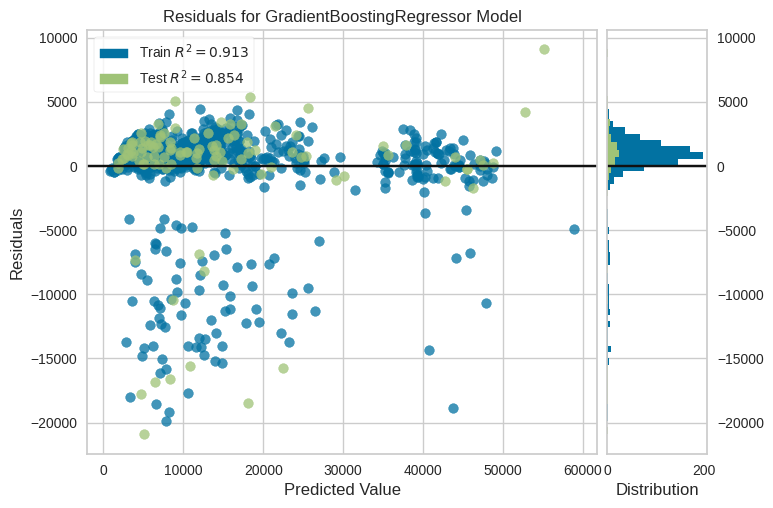

In [50]:
experiment.plot_model(best_model, 'residuals')

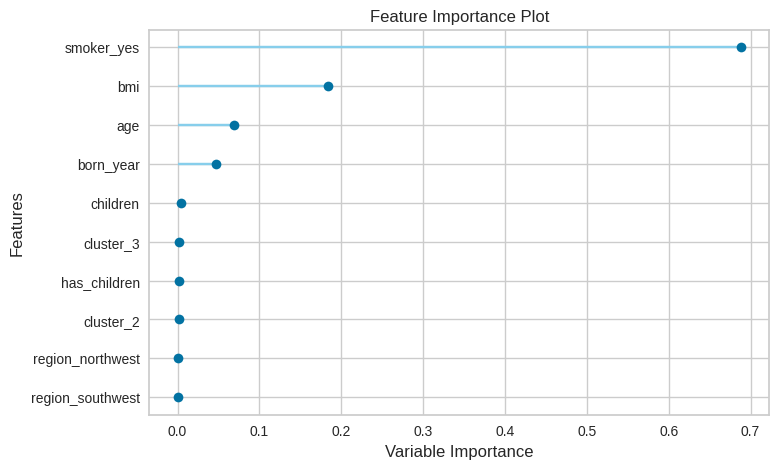

In [51]:
experiment.plot_model(best_model, 'feature')

In [52]:
# Faz previsões no conjunto de dados de validação (holdout)
predict_holdout = experiment.predict_model(best_model)
# A linha acima utiliza o melhor modelo de regressão para fazer previsões no conjunto de dados de validação (holdout).
# O resultado é armazenado na variável predict_holdout, que contém tanto as previsões quanto as verdadeiras etiquetas.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2766.2121,26190422.5069,5117.6579,0.8545,0.4262,0.2812


In [53]:
# Ajusta (tune) o melhor modelo selecionado
tuned_model = experiment.tune_model(best_model)
# A linha acima realiza a otimização de hiperparâmetros no melhor modelo de regressão selecionado (best_model).
# O resultado é um modelo ajustado (tuned_model) com os melhores hiperparâmetros encontrados durante o processo de ajuste.


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2880.2506,16509279.5043,4063.1613,0.8717,0.4200,0.3684
1,3227.4050,26185755.7756,5117.2019,0.8398,0.3521,0.2696
2,3180.8003,28822439.2350,5368.6534,0.8050,0.5250,0.3241
3,3864.4367,40972853.0697,6401.0041,0.7757,0.4603,0.3610
4,3061.5492,23753921.0553,4873.7994,0.8150,0.4298,0.3186
5,3161.0940,23295632.5940,4826.5549,0.8322,0.4943,0.3871
6,3203.4791,25304118.1137,5030.3199,0.8022,0.4163,0.3448
7,3081.0119,20779613.3579,4558.4661,0.8950,0.4556,0.3963
8,2933.1963,19704968.7904,4439.0279,0.8787,0.4422,0.3360


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [54]:
# Finaliza o modelo ajustado
tuned_model = experiment.finalize_model(tuned_model)
# A linha acima finaliza o modelo ajustado, o que significa que ele é treinado novamente usando todos os dados disponíveis.
# Isso inclui tanto os dados de treinamento quanto os dados de validação, garantindo que o modelo aproveite toda a informação disponível.


In [55]:
# Prepara o conjunto de dados de teste removendo a coluna alvo
X_test = validation_data.copy().drop("charges", axis=1)
# A linha acima cria uma cópia do conjunto de dados de validação e remove a coluna "charges", que é a coluna alvo.
# Isso resulta em X_test, que contém apenas as features usadas para fazer as previsões.

# Faz previsões no conjunto de dados de teste usando o modelo ajustado e finalizado
predictions = experiment.predict_model(tuned_model, data=X_test)
# A linha acima usa o modelo ajustado e finalizado (tuned_model) para fazer previsões no conjunto de dados X_test.
# O resultado é armazenado na variável predictions, que contém as previsões feitas pelo modelo.


**Explicação:**

- Ajustamos os hiperparâmetros do melhor modelo e finalizamos o treinamento usando todo o conjunto de dados.

### **5. Validação Estatística**

**Requisito:** Utilize métricas estatísticas para validar a eficácia do modelo (p-value, intervalos de confiança).

**Exemplo de Código e Resultados:**

In [56]:
# Calcula e imprime o Erro Quadrático Médio (MSE)
print(
    "MSE: ",
    mean_squared_error(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
# mean_squared_error: Calcula o erro quadrático médio entre os valores reais e previstos
# validation_data["charges"].values: Valores reais da coluna "charges" do conjunto de validação
# predictions["prediction_label"].values: Valores previstos pelo modelo

# Calcula e imprime o Erro Absoluto Médio (MAE)
print(
    "MAE: ",
    mean_absolute_error(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
# mean_absolute_error: Calcula o erro absoluto médio entre os valores reais e previstos
# validation_data["charges"].values: Valores reais da coluna "charges" do conjunto de validação
# predictions["prediction_label"].values: Valores previstos pelo modelo

# Calcula e imprime o Erro Absoluto Mediano (MedianAE)
print(
    "MedianAE: ",
    median_absolute_error(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
# median_absolute_error: Calcula o erro absoluto mediano entre os valores reais e previstos
# validation_data["charges"].values: Valores reais da coluna "charges" do conjunto de validação
# predictions["prediction_label"].values: Valores previstos pelo modelo

# Calcula e imprime a Variância Explicada
print(
    "Explained Variance: ",
    explained_variance_score(
        validation_data["charges"].values, predictions["prediction_label"].values
    ),
)
# explained_variance_score: Calcula a variância explicada pelas previsões em relação aos valores reais
# validation_data["charges"].values: Valores reais da coluna "charges" do conjunto de validação
# predictions["prediction_label"].values: Valores previstos pelo modelo

# Calcula e imprime o Coeficiente de Determinação (R²)
print(
    "R2: ",
    r2_score(validation_data["charges"].values, predictions["prediction_label"].values),
)
# r2_score: Calcula o coeficiente de determinação R², que indica a proporção da variância dos valores reais explicada pelas previsões
# validation_data["charges"].values: Valores reais da coluna "charges" do conjunto de validação
# predictions["prediction_label"].values: Valores previstos pelo modelo


MSE:  21347777.48973532
MAE:  2549.423004680249
MedianAE:  1436.7671082737547
Explained Variance:  0.8296214361876698
R2:  0.8292007828194683


In [57]:
# 5-Validação estatística
# Preparar os dados
X_test = validation_data.copy().drop("charges", axis=1)
X_test = sm.add_constant(X_test)  # Adicionar uma constante para o termo de interceptação
y_test = validation_data['charges']

# Usar as previsões do modelo para calcular os resíduos
residuals = y_test - predictions['prediction_label']


In [58]:
import statsmodels.api as sm

# Certifique-se de que os dados são numéricos
X_test = validation_data.copy().drop("charges", axis=1).astype(float)
y_test = validation_data['charges'].astype(float)

# Adicionar uma constante para o termo de interceptação
X_test_sm = sm.add_constant(X_test)

# Ajustar o modelo de regressão usando statsmodels
model = sm.OLS(y_test, X_test_sm).fit()

# Obter o sumário do modelo para ver p-valores e intervalos de confiança
model_summary = model.summary()
print(model_summary)

# Calcular intervalos de confiança para as previsões
predictions_sm = model.get_prediction(X_test_sm)
confidence_intervals = predictions_sm.conf_int()
#print(confidence_intervals)



                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     60.05
Date:                Mon, 27 May 2024   Prob (F-statistic):           3.56e-67
Time:                        17:42:21   Log-Likelihood:                -2698.7
No. Observations:                 268   AIC:                             5423.
Df Residuals:                     255   BIC:                             5470.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1135      0.013  

**Explicação:**

- Ajustamos um modelo de regressão com statsmodels para obter p-valores e intervalos de confiança.
- Validamos a eficácia do modelo com métricas estatísticas detalhadas.

### **Geração de Relatório em PDF**

**Requisito:** Elabore um relatório que inclua uma análise dos resultados, insights obtidos e validação estatística.

**Exemplo de Código e Resultados:**

In [59]:
# Função para gerar o relatório em PDF
def gerar_relatorio(model_summary, confidence_intervals):
    class PDF(FPDF):
        def header(self):
            self.set_font('Arial', 'B', 12)
            self.cell(0, 10, 'Relatório de Validação Estatística do Modelo de Regressão', 0, 1, 'C')
            self.ln(10)

        def chapter_title(self, title):
            self.set_font('Arial', 'B', 12)
            self.cell(0, 10, title, 0, 1, 'L')
            self.ln(5)

        def chapter_body(self, body):
            self.set_font('Arial', '', 12)
            self.multi_cell(0, 10, body)
            self.ln()

        def add_table(self, data):
            self.set_font('Arial', '', 12)
            col_width = self.epw / 4  # Column width
            th = self.font_size  # Text height

            for row in data:
                for item in row:
                    self.cell(col_width, th, str(item), border=1)
                self.ln(th)

    pdf = PDF()
    pdf.add_page()

    # Sumário do modelo
    pdf.chapter_title('Sumário do Modelo')
    model_summary_str = str(model_summary)
    pdf.chapter_body(model_summary_str)

    # Converter intervalos de confiança para DataFrame
    confidence_intervals_df = pd.DataFrame(confidence_intervals, columns=["lower_bound", "upper_bound"])

    # Intervalos de confiança
    pdf.chapter_title('Intervalos de Confiança')
    confidence_intervals_str = confidence_intervals_df.to_string()
    pdf.chapter_body(confidence_intervals_str)

    # Salvar PDF
    pdf.output('relatorio_modelo.pdf')

# Gerar o relatório
gerar_relatorio(model_summary, confidence_intervals)


**Explicação:**

- Usamos a biblioteca **`fpdf`** para gerar um relatório em PDF que inclui o sumário do modelo e os intervalos de confiança, tornando os resultados mais acessíveis e compreensíveis.